In [1]:
# Standard imports
import sys
import itertools
import glob

# Package imports
import numpy as np
import pandas as pd
from keras import models, layers
import matplotlib.pyplot as plt

# Local imports
import dutils
import drawing

%matplotlib inline
np.random.seed(2341)

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda4: GeForce GTX 1080 (0000:0B:00.0)


In [2]:
hits_row_names = ["event_id", "track_id", "i_r", "i_phi", "x", "y"]
particles_row_names = ["event_id", "p_id", "pt", "phi", "vx", "vy"]
n_r_bins = 9
n_phi_bins = 1000
max_tracks = 25
pt_scale = 2*np.pi/20000 # for loss function

def get_phi(x, y):
    return np.arctan2(y, x)

def discretize(evt, phiwidth):
    """
    evt: pandas dataframe holding hit information for one event
    phiwidth: size of pixel in phi direction
    
    Converts the hit information in the event into a numpy array with
    hits represented by 1's.
    """
    
    r_grid = np.arange(n_r_bins)
    phi_grid = np.arange(0., 2*np.pi, phiwidth)
    image = np.zeros((1, len(r_grid),len(phi_grid)))
    try:
        for hit in evt.itertuples():
            ir = hit[hits_row_names.index('i_r')]
            x = hit[hits_row_names.index('x')]
            y = hit[hits_row_names.index('y')]
            phi = get_phi(x, y)
            iphi = int((phi/phiwidth))
            image[0,ir,iphi] = 1
    except AttributeError:
        # This occurs if the event has only one hit (rare), in which case evt
        # is a Series, not a DataFrame.  Deal with this separately.
        print "Encountered event with only one hit:",evt
        
    return image

def get_targets(evt, max_tracks):
    """
    evt: pandas dataframe holding particle info for one event
    
    Gets the pt and phi of each particle in the event and returns them in a numpy array,
    scaled to an appropriate scale.
    """
    particles = np.zeros((max_tracks, 2))
    weights = np.zeros(max_tracks)
    try:
        for i,particle in enumerate(evt.itertuples()):
            if i >= max_tracks:
                break
            particles[i, 0] = particle[particles_row_names.index('pt')]*pt_scale
            particles[i, 1] = particle[particles_row_names.index('phi')]
            weights[i] = 1
        particles[:i+1] = particles[particles[:i+1,1].argsort()] # sort by second column (phi)
    except AttributeError:
        # This occurs if the event has only one particle, in which case evt is
        # a Series, not a DataFrame.  Deal with this separately.
        particles[0, 0] = evt['pt']*pt_scale
        particles[0, 1] = evt['phi']
        weights[0] = 1
    
    return particles, weights

In [3]:
def gen_single_hits(hit_files):
    cur_file = 0
    num_files = len(hit_files)
    while True:
        df = pd.read_csv(hit_files[cur_file], header=None, names=hits_row_names, index_col=hits_row_names[0])
        event_nums = sorted(df.index.unique())
        for event_num in event_nums:
            yield discretize(df.loc[event_num], phiwidth=2*np.pi/n_phi_bins)
        cur_file += 1
        if cur_file >= num_files:
            cur_file = 0

def gen_single_particles(particle_files, max_tracks):
    cur_file = 0
    num_files = len(particle_files)
    while True:
        df = pd.read_csv(particle_files[cur_file], header=None, names=particles_row_names, index_col=particles_row_names[0])
        event_nums = sorted(df.index.unique())
        for event_num in event_nums:
            yield get_targets(df.loc[event_num], max_tracks)
        cur_file += 1
        if cur_file >= num_files:
            cur_file = 0
    
def generate_data(batch_size, hit_files, particle_files, max_tracks=max_tracks):
    gen_hits = gen_single_hits(hit_files)
    gen_particles = gen_single_particles(particle_files, max_tracks)
    while True:
        batch_events = np.array([evt for evt in itertools.islice(gen_hits, batch_size)])
        batch_targets = np.zeros((batch_size, max_tracks, 2))
        batch_weights = np.zeros((batch_size, max_tracks))
        for i,(particles, weights) in enumerate(itertools.islice(gen_particles, batch_size)):
            batch_targets[i] = particles
            batch_weights[i] = weights
        yield batch_events, batch_targets, batch_weights

In [4]:
hit_files = sorted(glob.glob("hits_*.csv"))
particle_files = sorted(glob.glob("particles_*.csv"))
generator = generate_data(256, hit_files, particle_files)

In [5]:
hit_files

['hits_1000_3757.csv']

In [6]:
# Model
def build_model_1(max_tracks=max_tracks):
    input_layer = layers.Input(shape=(1, n_r_bins, n_phi_bins))
    
    layer1 = layers.Convolution2D(8, 2, 6, border_mode='same')(input_layer)
    layer1 = layers.Activation('relu')(layer1)
    layer1 = layers.Convolution2D(8, 2, 6, border_mode='same')(layer1)
    layer1 = layers.Activation('relu')(layer1)
    layer1 = layers.MaxPooling2D(pool_size=(1,4))(layer1)
    layer1 = layers.Convolution2D(16, 2, 6, border_mode='same')(layer1)
    layer1 = layers.Activation('relu')(layer1)
    layer1 = layers.Convolution2D(16, 2, 6, border_mode='same')(layer1)
    layer1 = layers.Activation('relu')(layer1)
    layer1 = layers.Flatten()(layer1)
    
    layer2 = layers.Convolution2D(8, 2, 12, border_mode='same')(input_layer)
    layer2 = layers.Activation('relu')(layer2)
    layer2 = layers.Convolution2D(8, 2, 12, border_mode='same')(layer2)
    layer2 = layers.Activation('relu')(layer2)
    layer2 = layers.MaxPooling2D(pool_size=(2,4))(layer2)
    layer2 = layers.Convolution2D(16, 2, 6, border_mode='same')(layer2)
    layer2 = layers.Activation('relu')(layer2)
    layer2 = layers.Convolution2D(16, 2, 6, border_mode='same')(layer2)
    layer2 = layers.Activation('relu')(layer2)
    layer2 = layers.Flatten()(layer2)
    
    layer3 = layers.Convolution2D(8, 4, 12, border_mode='same')(input_layer)
    layer3 = layers.Activation('relu')(layer3)
    layer3 = layers.Convolution2D(8, 4, 12, border_mode='same')(layer3)
    layer3 = layers.Activation('relu')(layer3)
    layer3 = layers.Flatten()(layer3)
    
    layer = layers.merge([layer1, layer2, layer3], mode='concat', concat_axis=1)
    layer = layers.Dense(1500)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(1500, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal")
    return model

In [9]:
model_1 = build_model_1()
%time model_1.fit_generator(generator, samples_per_epoch=96000, nb_epoch=3)

Epoch 1/3
96000/96000 [==============================] - 283s - loss: 1.7487   
Epoch 2/3
96000/96000 [==============================] - 279s - loss: 0.2522   
Epoch 3/3
96000/96000 [==============================] - 282s - loss: 0.0779   
CPU times: user 21min 36s, sys: 1min 25s, total: 23min 2s
Wall time: 15min 15s


In [11]:
model_1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 9, 1000)    0                                            
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 8, 9, 1000)    104         input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_25 (Convolution2D) (None, 8, 9, 1000)    200         input_3[0][0]                    
____________________________________________________________________________________________________
activation_21 (Activation)       (None, 8, 9, 1000)    0           convolution2d_21[0][0]           
___________________________________________________________________________________________

In [10]:
%time model_1.fit_generator(generator, samples_per_epoch=96000, nb_epoch=3)

Epoch 1/3
96000/96000 [==============================] - 282s - loss: 0.0059   
Epoch 2/3
96000/96000 [==============================] - 280s - loss: 0.0048   
Epoch 3/3
96000/96000 [==============================] - 279s - loss: 0.0418   
CPU times: user 20min 25s, sys: 1min 25s, total: 21min 50s
Wall time: 14min 3s


In [14]:
evt, truth, weight = generator.next()
#pred = model_1.predict(np.array([evt[0]]))
pred = model_1.predict(evt)
print "Model prediction"
print pred[0]
print "Target"
print truth[0]

Model prediction
[[-2.74826002 -2.08461905]
 [-2.42180514 -1.86076283]
 [-0.94125944  0.5341922 ]
 [ 1.79529238  0.98758322]
 [ 1.93143034  1.48636985]
 [ 0.30175659  2.12708139]
 [-1.64481544  2.45662189]
 [ 0.10591574  2.64216542]
 [-0.32537264  2.87597752]
 [-0.20989402  3.01825905]
 [-0.46605545  3.18709826]
 [ 0.15184098  3.35880232]
 [ 0.15897642  3.46378207]
 [-0.51322931  3.47783208]
 [-0.06549633  3.45491362]
 [-0.37501004  3.45733142]
 [-0.27224681  3.43733716]
 [-0.18250574  3.43333077]
 [-0.56146139  3.43123722]
 [-0.11936898  3.42740321]
 [-0.39738044  3.43205309]
 [-0.47276899  3.42569566]
 [-0.26943848  3.42722416]
 [-0.61154139  3.42187548]
 [-0.38508546  3.39153504]]
Target
[[-2.75004826 -2.08240334]
 [-2.42628142 -1.8752989 ]
 [-0.94993302  0.52392038]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 

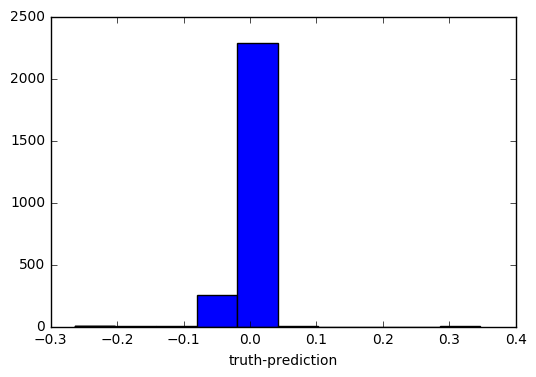

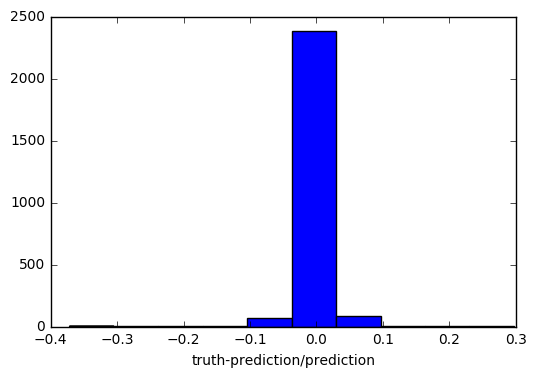

In [22]:
diff = []
relative_diff = []
for i in range( truth.shape[0]):
    t = truth[i]
    p = pred[i]
    one = np.where(t[:,0] !=0 )
    #print t[one,0]
    #print p[one,0]
    d  = (t[one,0] - p[one,0])
    rd = d /t[one,0] 
    diff.extend(d.ravel())
    relative_diff.extend(rd.ravel())


plt.hist(diff )
plt.xlabel('truth-prediction')
plt.show()

plt.hist(relative_diff )
plt.xlabel('truth-prediction/prediction')
plt.show()